In [24]:
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

import pickle
from collections import Counter


Let’s define the **representation** of a price group \( GPrice_q \) across all users:

$$
R(GPrice_q) = \frac{\text{Number of ratings to items in price group } q}{\text{Total number of ratings}}
$$

Then the **disparate visibility** becomes:

$$
\Delta V(GPrice_q) = \frac{\text{Number of recommended items in price group } q}{\text{Total number of recommendations}} - R(GPrice_q)
$$


In [25]:
def representation_visibility_cohhn(preprocess_path, recommendations_path, db):
    train_path = preprocess_path + "train.txt"
    with open(train_path, "rb") as f:
        data = pickle.load(f)

    # Unpack the relevant parts
    item_seqs = data[0]
    price_seqs = data[1]
    targets = data[7]

    # Build the DataFrame
    df = pd.DataFrame({
        'item_seq': item_seqs,
        'price_seq': price_seqs,
        'target': targets
    })

    # Flatten the list of price sequences
    all_prices = [price for sublist in df['price_seq'] for price in sublist]

    # Count occurrences
    price_counts = Counter(all_prices)

    # Total number of appearances
    total = sum(price_counts.values())

    # Calculate representation
    representation = {price: count / total for price, count in price_counts.items()}

    rep_df =  pd.DataFrame(list(representation.items()), columns=['price', 'representation']).sort_values(by='price')

    itemID2original_file = "itemID_to_asin_mapping.csv" if db == 'amazon' else "itemID_numeric_to_originalItemID_mapping.csv"
    original2price_file = "item_mapping_table.csv" if db == 'amazon' else "item_mapping_table_with_sequences.csv"

    cols = ['asin', "price_level"] if db == 'amazon' else ['itemID', 'priceLevel']

    amazon_recomm_ = pd.read_json(recommendations_path)
    id2originalID = pd.read_csv(preprocess_path + itemID2original_file)
    originalID2price = pd.read_csv(preprocess_path + original2price_file, usecols=cols)

    # Flatten the list of recommended item sequences
    all_items = [item for sublist in amazon_recomm_['recommended'] for item in sublist]

    if db == 'amazon': id2price = pd.merge(id2originalID, originalID2price, on='asin')
    else: 
        id2price = pd.merge(id2originalID, originalID2price, left_on='original_itemID', right_on='itemID')
        id2price = id2price.drop(columns='itemID')
        id2price = id2price.rename(columns={'itemID_numeric': 'itemID'})
        id2price = id2price.rename(columns={'priceLevel': 'price_level'})

    item_counter = Counter(all_items)
    id2price['count'] = id2price['itemID'].map(item_counter).fillna(0) # Shows how many times each item has been recommended
    
    # Group recommended item counts by price level
    price_grouped_counts = id2price.groupby('price_level')['count'].sum()

    # Total number of appearances
    total_ = len(all_items)

    # Calculate visibility
    visibility = {price: (count / total_)-representation[price] for price, count in price_grouped_counts.items()}
    vis_df =  pd.DataFrame(list(visibility.items()), columns=['price', 'visibility']).sort_values(by='price')
    
    return pd.merge(rep_df, vis_df, on='price')

In [26]:
amazon_p2 = representation_visibility_cohhn("CoHHN/Grocery_and_Gourmet_Food/price_level_2/Grocery_and_Gourmet_Food/", "recommendation_lists/CoHHN/Grocery_and_Gourmet_Food/price_level_2/output/recommendations_top20.json", 'amazon')
amazon_p2.to_csv('results/cohhn_amazon_metrics_p2.csv', index=False)

amazon_p10 = representation_visibility_cohhn("CoHHN/Grocery_and_Gourmet_Food/price_level_10/Grocery_and_Gourmet_Food/", "recommendation_lists/CoHHN/Grocery_and_Gourmet_Food/price_level_10/recommendations_top20.json", 'amazon')
amazon_p10.to_csv('results/cohhn_amazon_metrics_p10.csv', index=False)

amazon_p50 = representation_visibility_cohhn("CoHHN/Grocery_and_Gourmet_Food/price_level_50/Grocery_and_Gourmet_Food/", "recommendation_lists/CoHHN/Grocery_and_Gourmet_Food/price_level_50/recommendations_top20.json", 'amazon')
amazon_p50.to_csv('results/cohhn_amazon_metrics_p50.csv', index=False)

diginetica_p2 = representation_visibility_cohhn("CoHHN/DigineticaBuy/price_level_2/digineticaBuy/", "recommendation_lists/CoHHN/DigineticaBuy/price_level_2/recommendations_top20.json", 'diginetica')
diginetica_p2.to_csv('results/cohhn_diginetica_metrics_p2.csv', index=False)

diginetica_p10 = representation_visibility_cohhn("CoHHN/DigineticaBuy/price_level_10/digineticaBuy/", "recommendation_lists/CoHHN/DigineticaBuy/price_level_10/recommendations_top20.json", 'diginetica')
diginetica_p10.to_csv('results/cohhn_diginetica_metrics_p10.csv', index=False)

diginetica_p50 = representation_visibility_cohhn("CoHHN/DigineticaBuy/price_level_50/digineticaBuy/", "recommendation_lists/CoHHN/DigineticaBuy/price_level_50/recommendations_top20.json", 'diginetica')
diginetica_p50.to_csv('results/cohhn_diginetica_metrics_p50.csv', index=False)

In [27]:
def representation_visibility_pasbr(preprocess_path, recommendations_path, db):
    train_path = preprocess_path + "train.pkl"
    with open(train_path, "rb") as f:
        data = pickle.load(f)

    if db == 'diginetica':
        niid2priceid = pd.read_csv(preprocess_path + 'niid_2_priceid.txt', header=None)
        niid2priceid.columns = ['id', 'price']

        item_seqs = []
        price_seqs = []
        price_lookup = dict(zip(niid2priceid['id'], niid2priceid['price']))

        for x in data:
            item_seqs.append(x[0])
            temp = [price_lookup.get(int(item), 0) for item in x[0]]
            price_seqs.append(temp)
    
    else:
        # Unpack the relevant parts
        item_seqs = [x[0] for x in data]
        price_seqs = [x[2] for x in data]


    # Build the DataFrame
    df = pd.DataFrame({
        'item_seq': item_seqs,
        'price_seq': price_seqs
    })

    # Flatten the list of price sequences
    all_prices = [price for sublist in df['price_seq'] for price in sublist]

    # Count occurrences
    price_counts = Counter(all_prices)

    # Total number of appearances
    total = sum(price_counts.values())

    # Calculate representation
    representation = {price: count / total for price, count in price_counts.items()}
    representation = {int(k): v for k, v in representation.items()}

    rep_df =  pd.DataFrame(list(representation.items()), columns=['price', 'representation']).sort_values(by='price')

    itemID2original_file = "itemID_numeric_to_originalItemID_mapping.csv"

    amazon_recomm_ = pd.read_json(recommendations_path)
    id2originalID = pd.read_csv(preprocess_path + itemID2original_file)

    if db == 'amazon':
        original2price_file = "item_mapping_table_with_sequences.csv"
        itemID2original_file = "itemID_numeric_to_originalItemID_mapping.csv"
        cols = ['original_itemID', "price_levelID"]
        originalID2price = pd.read_csv(preprocess_path + original2price_file, usecols=cols)


    # Flatten the list of recommended item sequences
    all_items = [item for sublist in amazon_recomm_['recommended'] for item in sublist]

    item_counter = Counter(all_items)

    if db == 'diginetica':
        id2originalID['count'] = id2originalID['numeric_itemID'].map(item_counter) # Shows how many times each item has been recommended
        id2originalID['price_level'] = id2originalID['numeric_itemID'].map(price_lookup)
        # Group recommended item counts by price level
        price_grouped_counts = id2originalID.groupby('price_level')['count'].sum()
    else:
        id2price = pd.merge(id2originalID, originalID2price, on='original_itemID')
        id2price['count'] = id2price['numeric_itemID'].map(item_counter).fillna(0)
        # Group recommended item counts by price level
        price_grouped_counts = id2price.groupby('price_levelID')['count'].sum()

    # Total number of appearances
    total_ = len(all_items)

    # Calculate visibility
    visibility = {price: (count / total_)-representation[price] for price, count in price_grouped_counts.items()}
    vis_df =  pd.DataFrame(list(visibility.items()), columns=['price', 'visibility']).sort_values(by='price')
    
    return pd.merge(rep_df, vis_df, on='price')

In [28]:
amazon_p2 = representation_visibility_pasbr("PASBR/Amazon/amazon_pasbr_pricelevel_2_Grocery_and_Gourmet_Food/", "recommendation_lists/PASBR/Grocery_and_Gourmet_Food/price_level_2/recommendations_20250605_033139_k20_target_format.json", 'amazon')
amazon_p2.to_csv('results/pasbr_amazon_metrics_p2.csv', index=False)

amazon_p10 = representation_visibility_pasbr("PASBR/Amazon/amazon_pasbr_pricelevel_10_Grocery_and_Gourmet_Food/", "recommendation_lists/PASBR/Grocery_and_Gourmet_Food/price_level_10/recommendations_20250605_033139_k20_target_format.json", 'amazon')
amazon_p10.to_csv('results/pasbr_amazon_metrics_p10.csv', index=False)

amazon_p50 = representation_visibility_pasbr("PASBR/Amazon/amazon_pasbr_pricelevel_50_Grocery_and_Gourmet_Food/", "recommendation_lists/PASBR/Grocery_and_Gourmet_Food/price_level_50/recommendations_20250605_033139_k20_target_format.json", 'amazon')
amazon_p50.to_csv('results/pasbr_amazon_metrics_p50.csv', index=False)

diginetica_p2 = representation_visibility_pasbr("PASBR/DigineticaBuy/diginetica_pasbr_pricelevel_2/", "recommendation_lists/PASBR/DigineticaBuy/price_level_2/recommendations_20250604_103210_k20_target_format.json", 'diginetica')
diginetica_p2.to_csv('results/pasbr_diginetica_metrics_p2.csv', index=False)

diginetica_p10 = representation_visibility_pasbr("PASBR/DigineticaBuy/diginetica_pasbr_pricelevel_10/", "recommendation_lists/PASBR/DigineticaBuy/price_level_10/recommendations_20250604_071213_k20_target_format.json", 'diginetica')
diginetica_p10.to_csv('results/pasbr_diginetica_metrics_p10.csv', index=False)

diginetica_p50 = representation_visibility_pasbr("PASBR/DigineticaBuy/diginetica_pasbr_pricelevel_50/", "recommendation_lists/PASBR/DigineticaBuy/price_level_50/recommendations_20250604_042929_k20_target_format.json", 'diginetica')
diginetica_p50.to_csv('results/pasbr_diginetica_metrics_p50.csv', index=False)

In [29]:
# Load data
cohhn_amazon_p2 = pd.read_csv("results/cohhn_amazon_metrics_p2.csv")
cohhn_amazon_p10 = pd.read_csv("results/cohhn_amazon_metrics_p10.csv")
cohhn_amazon_p50 = pd.read_csv("results/cohhn_amazon_metrics_p50.csv")

cohhn_diginetica_p2 = pd.read_csv("results/cohhn_diginetica_metrics_p2.csv")
cohhn_diginetica_p10 = pd.read_csv("results/cohhn_diginetica_metrics_p10.csv")
cohhn_diginetica_p50 = pd.read_csv("results/cohhn_diginetica_metrics_p50.csv")

pasbr_amazon_p2 = pd.read_csv("results/pasbr_amazon_metrics_p2.csv")
pasbr_amazon_p10 = pd.read_csv("results/pasbr_amazon_metrics_p10.csv")
pasbr_amazon_p50 = pd.read_csv("results/pasbr_amazon_metrics_p50.csv")

pasbr_diginetica_p2 = pd.read_csv("results/pasbr_diginetica_metrics_p2.csv")
pasbr_diginetica_p10 = pd.read_csv("results/pasbr_diginetica_metrics_p10.csv")
pasbr_diginetica_p50 = pd.read_csv("results/pasbr_diginetica_metrics_p50.csv")

# Helper function to plot with exact x-ticks and value labels
def plot_with_labels(ax, x, y, title, ylabel, color='blue', chart='representation'):
    ax.plot(x, y, marker='o', color=color)
    ax.set_title(title)
    ax.set_xlabel('Preus')
    ax.set_ylabel(ylabel)
    ax.set_xticks(x) 
    ax.set_xmargin(0.01)
    if chart == 'visibility': ax.axhline(0, color='gray', linestyle='--', linewidth=1.5)
    for i, val in enumerate(y):
        ax.annotate(f"{val:.2f}", (x[i], y[i]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)


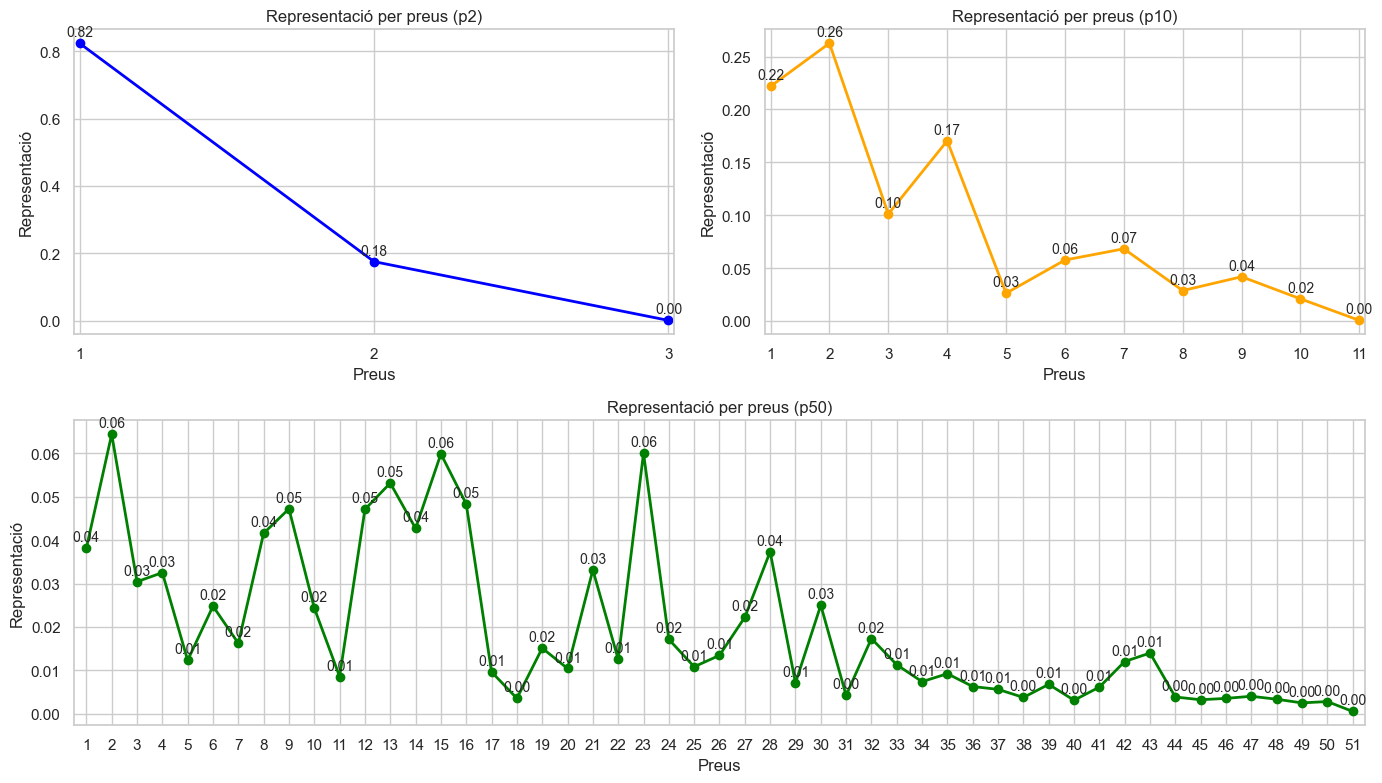

In [30]:
# Create layout
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Top-left
ax1 = fig.add_subplot(gs[0, 0])
plot_with_labels(ax1, cohhn_amazon_p2['price'], cohhn_amazon_p2['representation'], 'Representació per preus (p2)', 'Representació')

# Top-right
ax2 = fig.add_subplot(gs[0, 1])
plot_with_labels(ax2, cohhn_amazon_p10['price'], cohhn_amazon_p10['representation'], 'Representació per preus (p10)', 'Representació', color='orange')

# Bottom full-width
ax3 = fig.add_subplot(gs[1, :])
plot_with_labels(ax3, cohhn_amazon_p50['price'], cohhn_amazon_p50['representation'], 'Representació per preus (p50)', 'Representació', color='green')

plt.tight_layout()
plt.show()

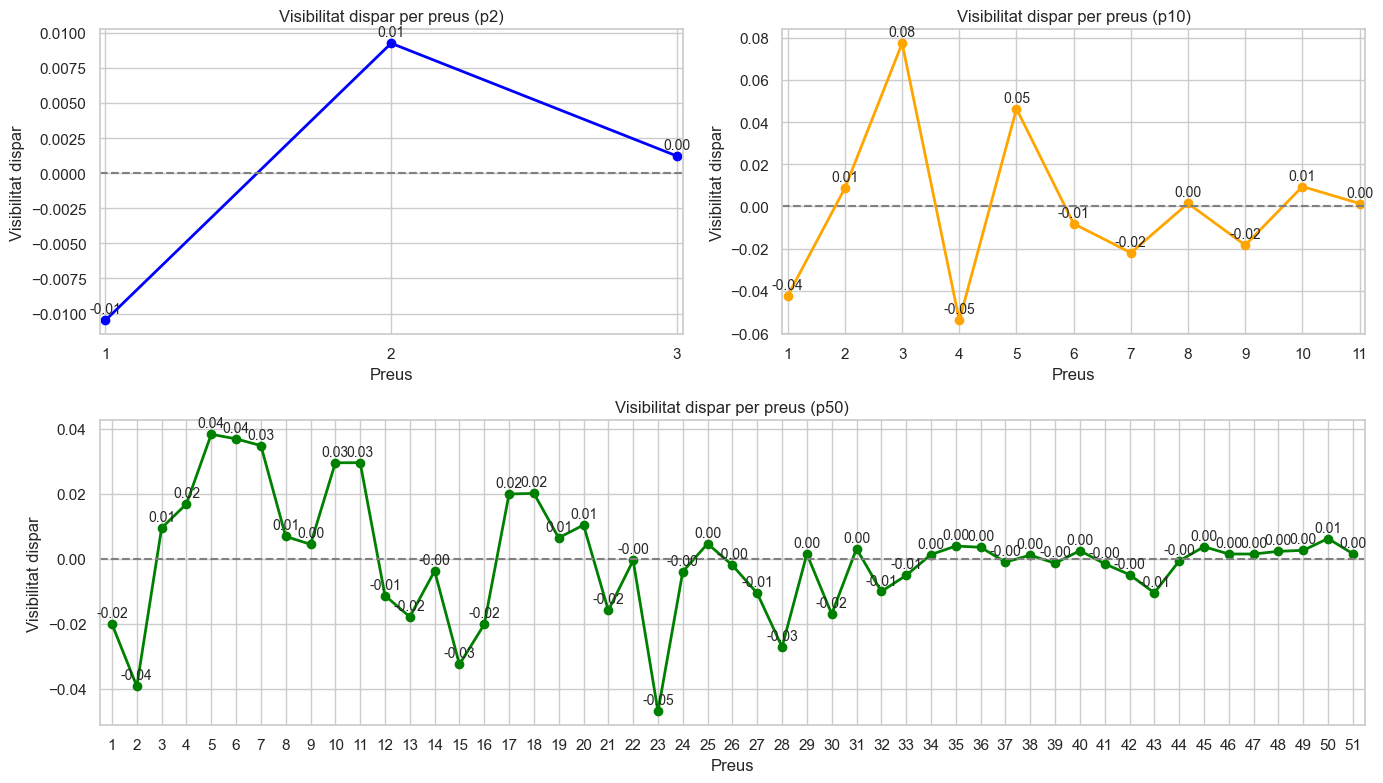

In [31]:
# Create layout
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Top-left
ax1 = fig.add_subplot(gs[0, 0])
plot_with_labels(ax1, cohhn_amazon_p2['price'], cohhn_amazon_p2['visibility'], 'Visibilitat dispar per preus (p2)', 'Visibilitat dispar', chart='visibility')

# Top-right
ax2 = fig.add_subplot(gs[0, 1])
plot_with_labels(ax2, cohhn_amazon_p10['price'], cohhn_amazon_p10['visibility'], 'Visibilitat dispar per preus (p10)', 'Visibilitat dispar', color='orange', chart='visibility')

# Bottom full-width
ax3 = fig.add_subplot(gs[1, :])
plot_with_labels(ax3, cohhn_amazon_p50['price'], cohhn_amazon_p50['visibility'], 'Visibilitat dispar per preus (p50)', 'Visibilitat dispar', color='green', chart='visibility')

plt.tight_layout()
plt.show()

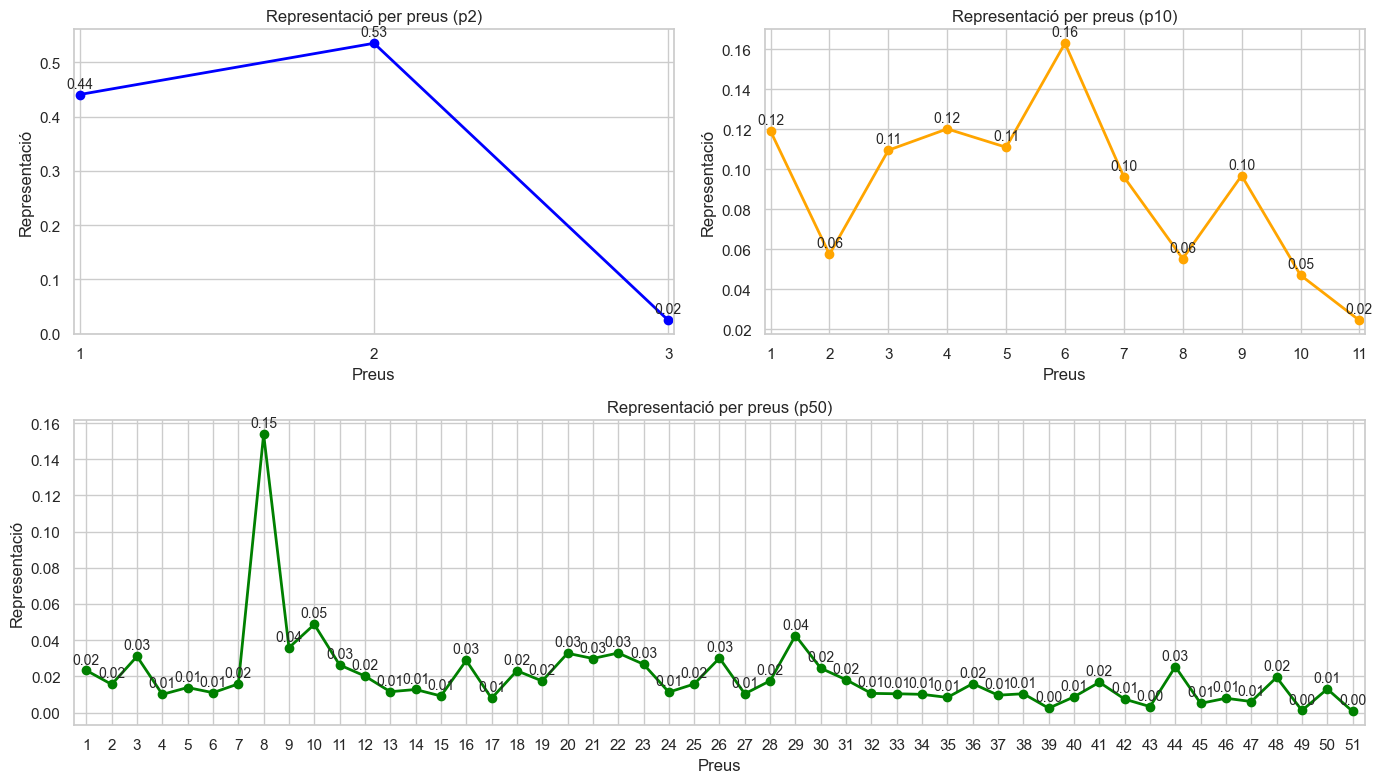

In [32]:
# Create layout
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Top-left
ax1 = fig.add_subplot(gs[0, 0])
plot_with_labels(ax1, cohhn_diginetica_p2['price'], cohhn_diginetica_p2['representation'], 'Representació per preus (p2)', 'Representació')

# Top-right
ax2 = fig.add_subplot(gs[0, 1])
plot_with_labels(ax2, cohhn_diginetica_p10['price'], cohhn_diginetica_p10['representation'], 'Representació per preus (p10)', 'Representació', color='orange')

# Bottom full-width
ax3 = fig.add_subplot(gs[1, :])
plot_with_labels(ax3, cohhn_diginetica_p50['price'], cohhn_diginetica_p50['representation'], 'Representació per preus (p50)', 'Representació', color='green')

plt.tight_layout()
plt.show()

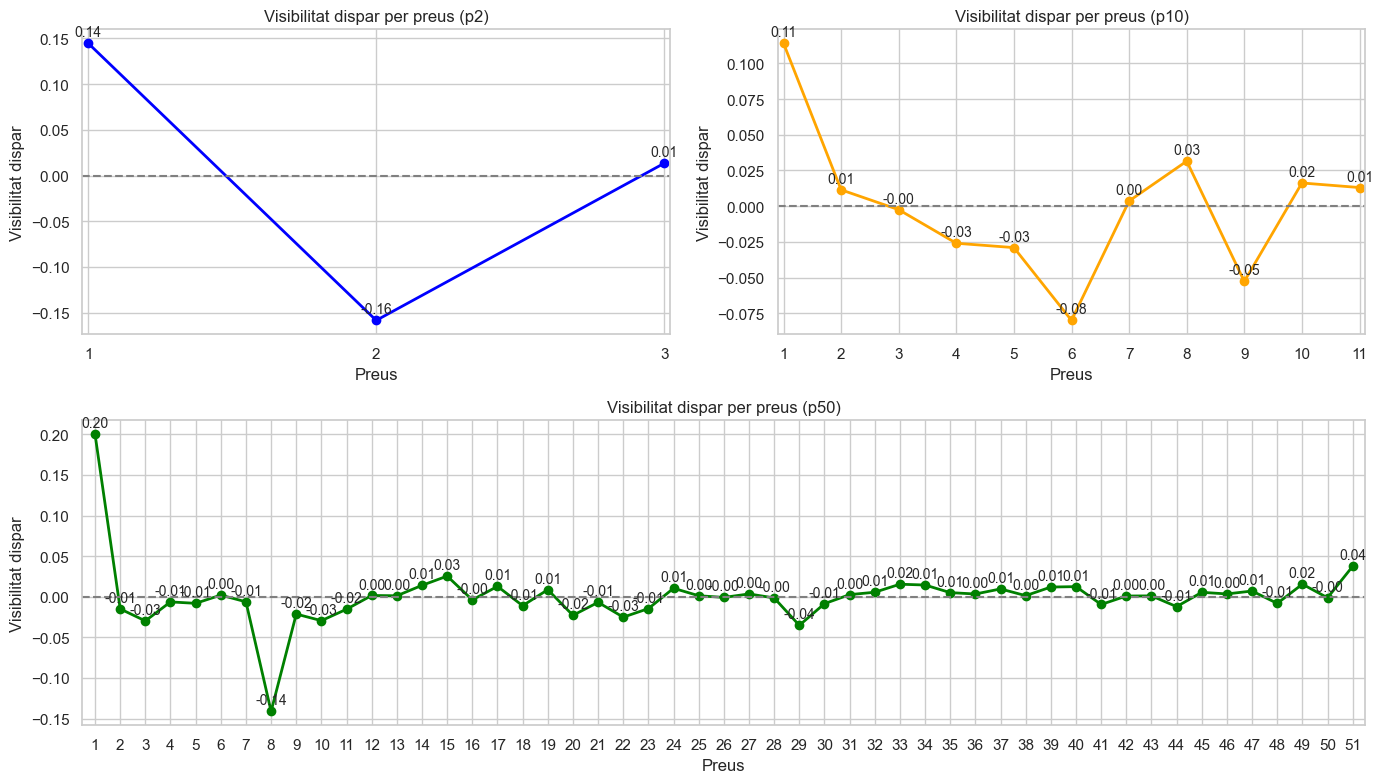

In [33]:
# Create layout
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Top-left
ax1 = fig.add_subplot(gs[0, 0])
plot_with_labels(ax1, cohhn_diginetica_p2['price'], cohhn_diginetica_p2['visibility'], 'Visibilitat dispar per preus (p2)', 'Visibilitat dispar', chart='visibility')

# Top-right
ax2 = fig.add_subplot(gs[0, 1])
plot_with_labels(ax2, cohhn_diginetica_p10['price'], cohhn_diginetica_p10['visibility'], 'Visibilitat dispar per preus (p10)', 'Visibilitat dispar', color='orange', chart='visibility')

# Bottom full-width
ax3 = fig.add_subplot(gs[1, :])
plot_with_labels(ax3, cohhn_diginetica_p50['price'], cohhn_diginetica_p50['visibility'], 'Visibilitat dispar per preus (p50)', 'Visibilitat dispar', color='green', chart='visibility')

plt.tight_layout()
plt.show()

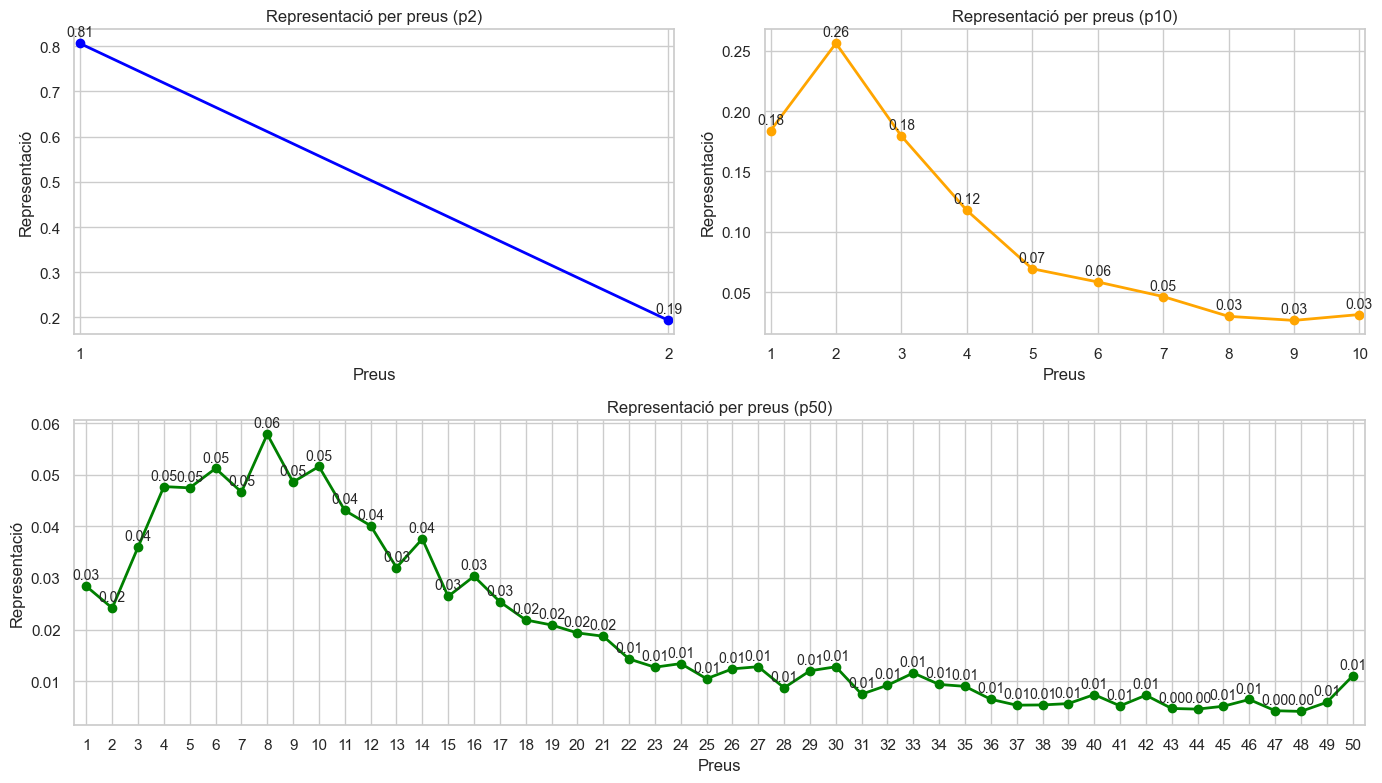

In [34]:
# Create layout
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Top-left
ax1 = fig.add_subplot(gs[0, 0])
plot_with_labels(ax1, pasbr_amazon_p2['price'], pasbr_amazon_p2['representation'], 'Representació per preus (p2)', 'Representació')

# Top-right
ax2 = fig.add_subplot(gs[0, 1])
plot_with_labels(ax2, pasbr_amazon_p10['price'], pasbr_amazon_p10['representation'], 'Representació per preus (p10)', 'Representació', color='orange')

# Bottom full-width
ax3 = fig.add_subplot(gs[1, :])
plot_with_labels(ax3, pasbr_amazon_p50['price'], pasbr_amazon_p50['representation'], 'Representació per preus (p50)', 'Representació', color='green')

plt.tight_layout()
plt.show()

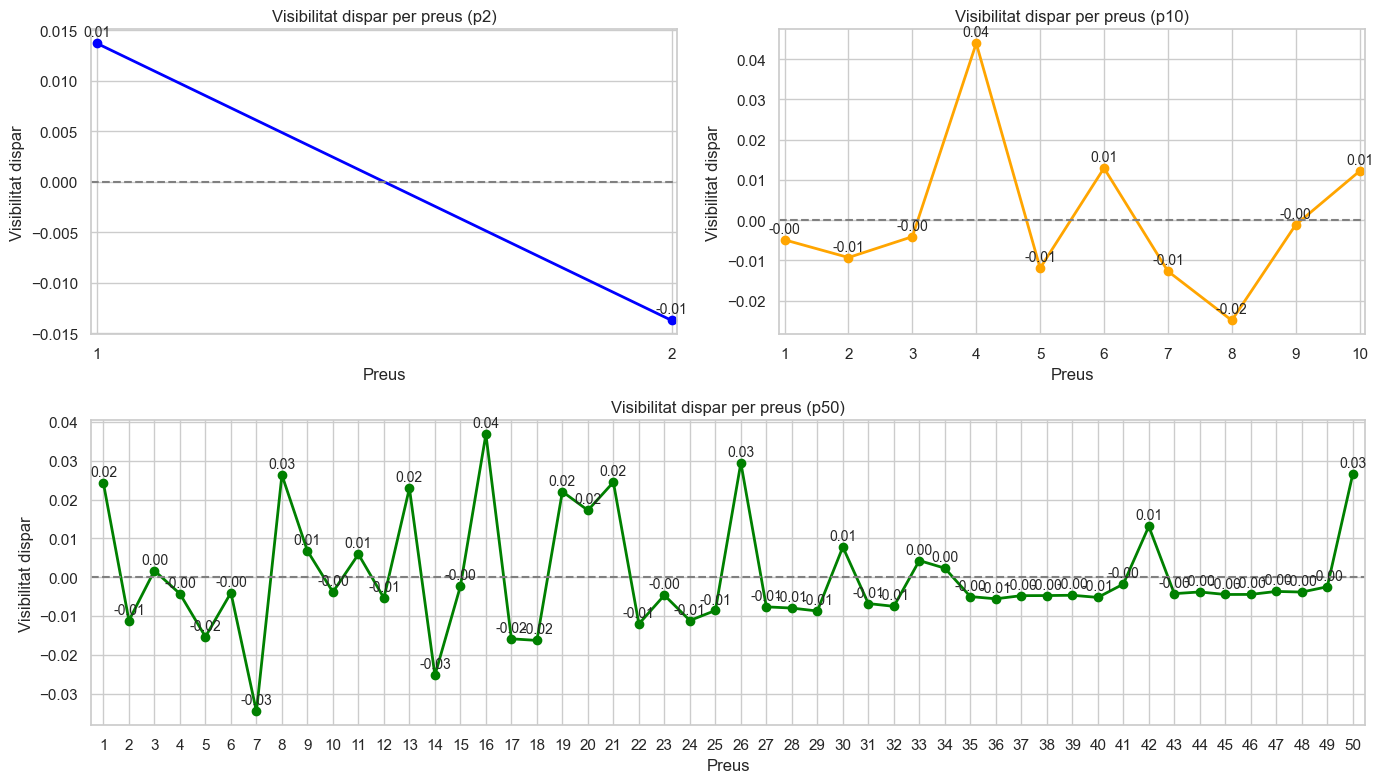

In [35]:
# Create layout
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Top-left
ax1 = fig.add_subplot(gs[0, 0])
plot_with_labels(ax1, pasbr_amazon_p2['price'], pasbr_amazon_p2['visibility'], 'Visibilitat dispar per preus (p2)', 'Visibilitat dispar', chart='visibility')

# Top-right
ax2 = fig.add_subplot(gs[0, 1])
plot_with_labels(ax2, pasbr_amazon_p10['price'], pasbr_amazon_p10['visibility'], 'Visibilitat dispar per preus (p10)', 'Visibilitat dispar', color='orange', chart='visibility')

# Bottom full-width
ax3 = fig.add_subplot(gs[1, :])
plot_with_labels(ax3, pasbr_amazon_p50['price'], pasbr_amazon_p50['visibility'], 'Visibilitat dispar per preus (p50)', 'Visibilitat dispar', color='green', chart='visibility')

plt.tight_layout()
plt.show()

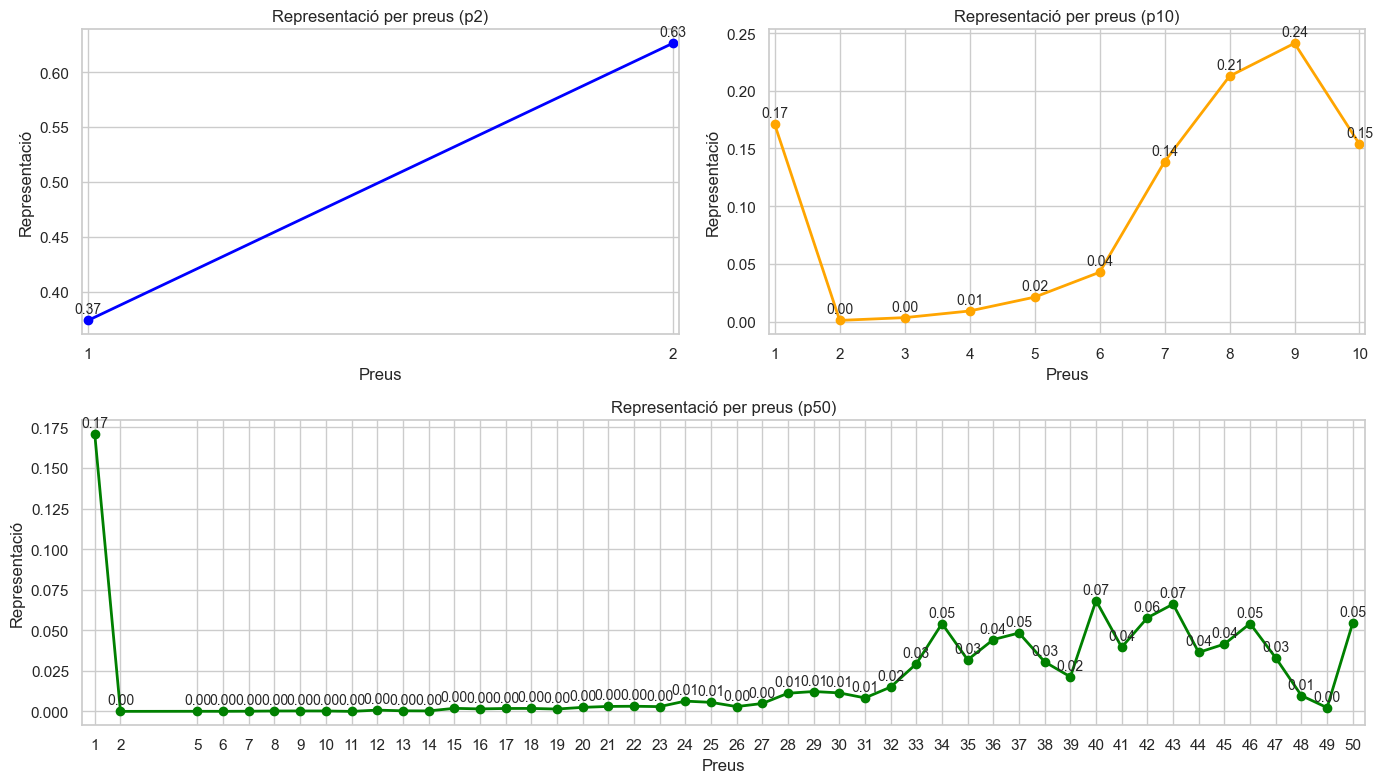

In [36]:
# Create layout
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Top-left
ax1 = fig.add_subplot(gs[0, 0])
plot_with_labels(ax1, pasbr_diginetica_p2['price'], pasbr_diginetica_p2['representation'], 'Representació per preus (p2)', 'Representació')

# Top-right
ax2 = fig.add_subplot(gs[0, 1])
plot_with_labels(ax2, pasbr_diginetica_p10['price'], pasbr_diginetica_p10['representation'], 'Representació per preus (p10)', 'Representació', color='orange')

# Bottom full-width
ax3 = fig.add_subplot(gs[1, :])
plot_with_labels(ax3, pasbr_diginetica_p50['price'], pasbr_diginetica_p50['representation'], 'Representació per preus (p50)', 'Representació', color='green')

plt.tight_layout()
plt.show()

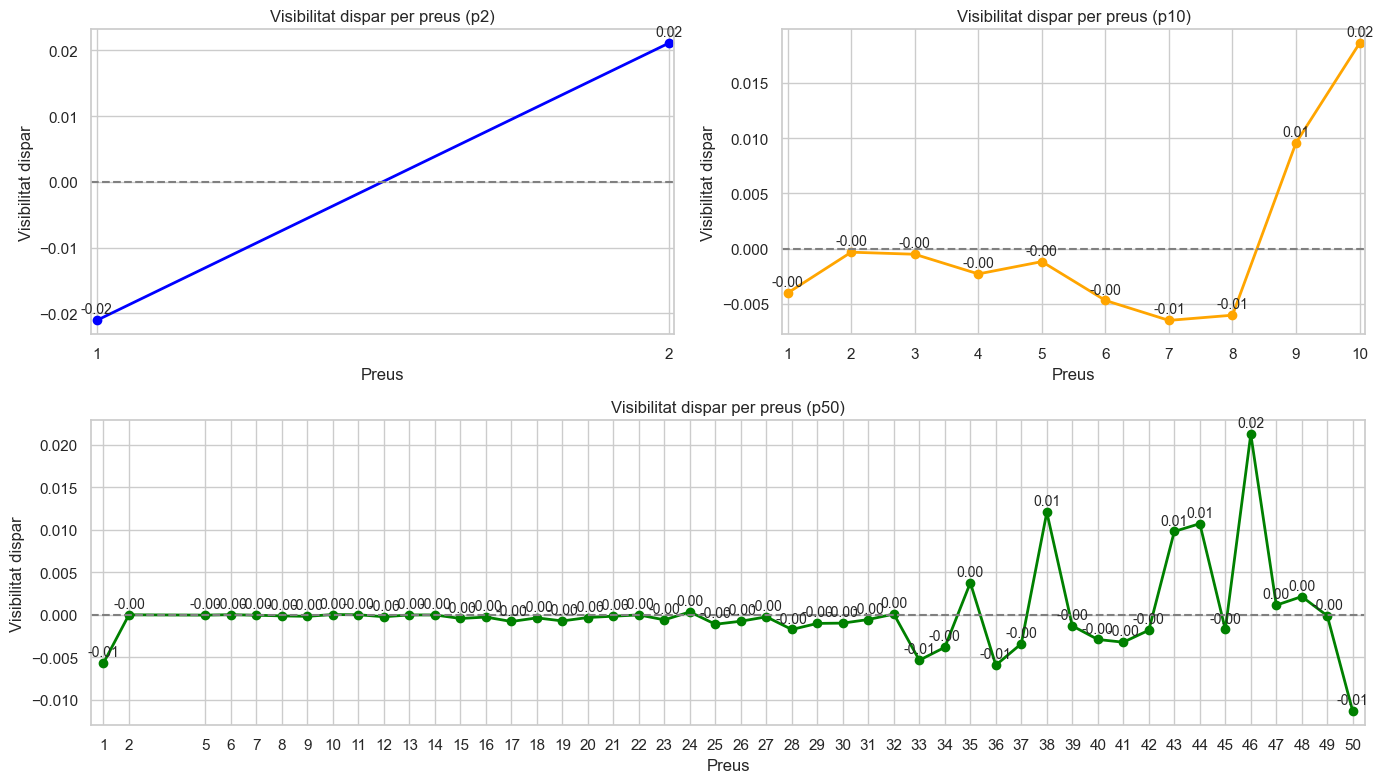

In [37]:
# Create layout
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Top-left
ax1 = fig.add_subplot(gs[0, 0])
plot_with_labels(ax1, pasbr_diginetica_p2['price'], pasbr_diginetica_p2['visibility'], 'Visibilitat dispar per preus (p2)', 'Visibilitat dispar', chart='visibility')

# Top-right
ax2 = fig.add_subplot(gs[0, 1])
plot_with_labels(ax2, pasbr_diginetica_p10['price'], pasbr_diginetica_p10['visibility'], 'Visibilitat dispar per preus (p10)', 'Visibilitat dispar', color='orange', chart='visibility')

# Bottom full-width
ax3 = fig.add_subplot(gs[1, :])
plot_with_labels(ax3, pasbr_diginetica_p50['price'], pasbr_diginetica_p50['visibility'], 'Visibilitat dispar per preus (p50)', 'Visibilitat dispar', color='green', chart='visibility')

plt.tight_layout()
plt.show()